In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
users = pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1")
engagement = pd.read_csv('takehome_user_engagement.csv',encoding = "ISO-8859-1")

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [6]:
engagement.head(2)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


## Clean Data
- users
- engagement

## users

In [7]:
users.apply(lambda x: sum(x.isnull()))

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

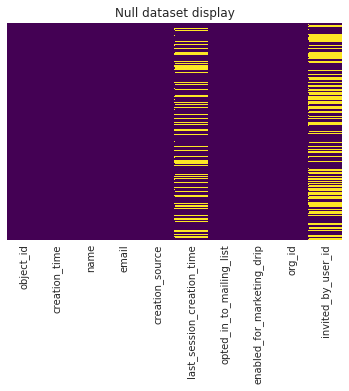

In [8]:
sns.heatmap(users.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Null dataset display')
plt.show()

In [9]:
users.invited_by_user_id.fillna(0,inplace=True)  # change null to 0 

### change dtypes

In [10]:
users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [11]:
users.creation_source = users.creation_source.astype('category')
users.invited_by_user_id= users.invited_by_user_id.astype('int')

In [12]:
users.invited_by_user_id.value_counts(dropna=False)[:10]

0        5583
10741      13
2527       12
11770      11
2308       11
1525       11
4302       10
10481      10
2354       10
4803       10
Name: invited_by_user_id, dtype: int64

#### egagement
- change dtypes for engagement

In [13]:
engagement.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [14]:
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)
engagement.set_index(engagement.time_stamp,inplace=True)
engagement.drop(['time_stamp'],axis=1,inplace=True)
engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


## Find how many users were logged in each week
- group user_id by week

In [15]:
grouped = engagement.groupby('user_id').resample('W')['visited',].sum()

In [16]:
grouped = grouped[grouped.visited>0]  # no 0 visits

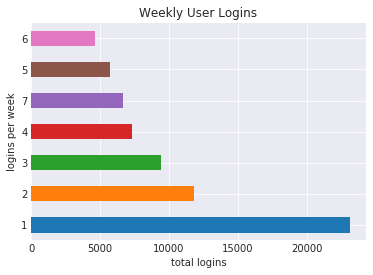

In [17]:
grouped.visited.value_counts().plot('barh')
plt.title('Weekly User Logins')
plt.xlabel('total logins')
plt.ylabel('logins per week')
plt.show()

## create filters for each option
- select active users who were on >= 3 days in each week

In [18]:
active_users = grouped.visited >= 3
active_users = active_users.groupby(level=0).apply(np.sum)
active_users = pd.DataFrame(active_users[active_users!=0])

In [19]:
active_users['active'] = 1
active_users.drop(['visited'],axis=1,inplace=True)
active_users.head()

,active
user_id,
2,1
10,1
20,1
33,1
42,1


### Merge with user data on object_id

In [20]:
data = active_users.merge(users,left_index=True,right_on='object_id',how='outer')
data = data.set_index('object_id').sort_index()
data.active.fillna(0,inplace=True)
data.active = data.active.astype('int')

In [21]:
data.head()

,active,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,,
1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803
2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316
3,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525
4,0,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151
5,0,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240


In [22]:
data.active.value_counts()

0    10555
1     1445
Name: active, dtype: int64

## Explore Data

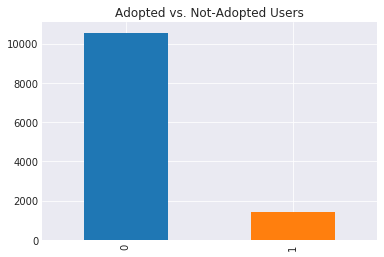

In [23]:
data.active.value_counts().plot('bar')
plt.title('Adopted vs. Not-Adopted Users')
plt.show()

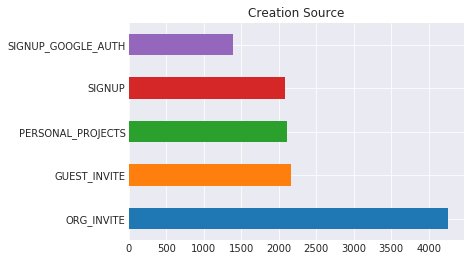

In [24]:
data.creation_source.value_counts().plot('barh')
plt.title('Creation Source')
plt.show()

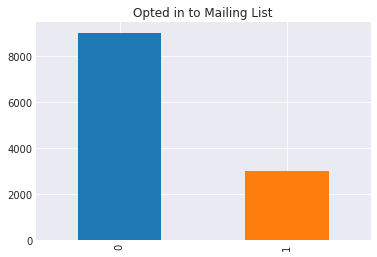

In [25]:
data.opted_in_to_mailing_list.value_counts().plot('bar')
plt.title('Opted in to Mailing List')
plt.show()

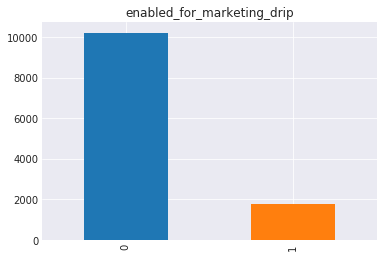

In [26]:
# enabled_for_marketing_drip
data.enabled_for_marketing_drip.value_counts().plot('bar')
plt.title('enabled_for_marketing_drip')
plt.show()

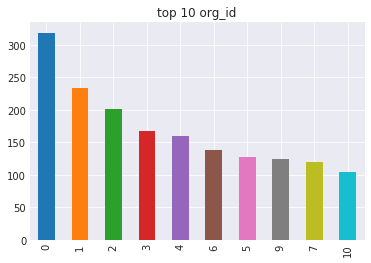

In [27]:
data.org_id.value_counts()[:10].plot('bar')
plt.title('top 10 org_id')
plt.show()

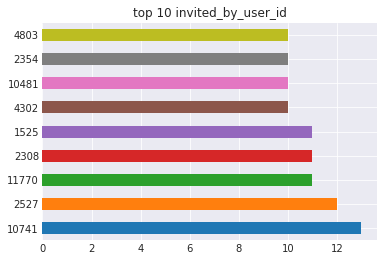

In [28]:
# invided by user id
data.invited_by_user_id.value_counts()[1:10].plot('barh')
plt.title('top 10 invited_by_user_id')
plt.show()

In [29]:
# invite or no invide
data.invited_by_user_id = data.invited_by_user_id.apply(lambda x: 1 if x!=0 else 0)

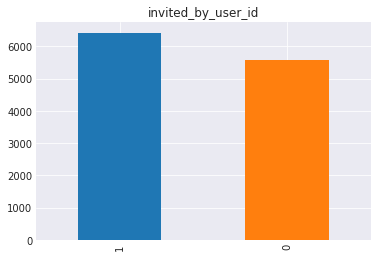

In [32]:
# invided by user id
data.invited_by_user_id.value_counts().plot('bar')
plt.title('invited_by_user_id')
plt.show()

In [ ]:
data.head()

### Models
- remove unecessary columns

In [33]:
data.apply(lambda x: sum(x.isnull()))

active                           0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id               0
dtype: int64

In [34]:
data.invited_by_user_id.value_counts()[:10]

1    6417
0    5583
Name: invited_by_user_id, dtype: int64

In [ ]:
#data.invited_by_user_id = data.invited_by_user_id.apply(lambda x: 1 if x!=0 else 0)

In [35]:
model_data = data.drop([ 'name', 'email','creation_time','last_session_creation_time'],axis=1)
model_data.head()

,active,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,
1,0,GUEST_INVITE,1,0,11,1
2,1,ORG_INVITE,0,0,1,1
3,0,ORG_INVITE,0,0,94,1
4,0,GUEST_INVITE,0,0,1,1
5,0,GUEST_INVITE,0,0,193,1


In [36]:
model_data =  pd.get_dummies(model_data, columns = ['creation_source'])
model_data.head()

,active,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,
1,0,1,0,11,1,1,0,0,0,0
2,1,0,0,1,1,0,1,0,0,0
3,0,0,0,94,1,0,1,0,0,0
4,0,0,0,1,1,1,0,0,0,0
5,0,0,0,193,1,1,0,0,0,0


In [37]:
X = model_data.drop('active', axis=1)
y = model_data['active']

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# clf = RandomForestClassifier(bootstrap =False, 
#                              criterion =  'entropy', 
#                              min_samples_split= 10,
#                             n_estimators=50)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [40]:
score = clf.score(X_test, y_test)
print("accuracy:   %0.3f" % score)

accuracy:   0.833


In [41]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      0.94      0.91      3483
          1       0.14      0.08      0.10       477

avg / total       0.79      0.83      0.81      3960



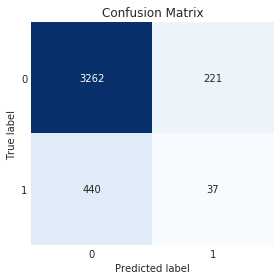

In [42]:
title = 'Confusion Matrix'
labels =list(np.unique(y))
cm = confusion_matrix(y_test, y_pred,labels=labels)
plt.figure(figsize = (4,4))
g = sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues",xticklabels=True,yticklabels=True)
g.set_yticklabels(labels, rotation =0)
g.set_xticklabels(labels, rotation =0)
plt.title(title)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

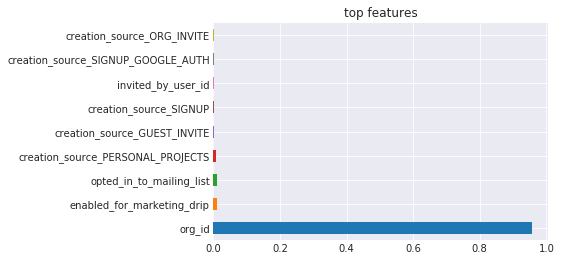

In [43]:
pd.Series(clf.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh') 
plt.title('top features')
plt.show()

#### Top features
- `org_id`

Lets expand `org_id`

In [44]:
# Train and Test Accuracy
print( "Train Accuracy : {}".format(accuracy_score(y_train, clf.predict(X_train))))
print( "Test Accuracy  : {}".format(accuracy_score(y_test, y_pred)))

Train Accuracy : 0.9098258706467661
Test Accuracy  : 0.8330808080808081


## Expand `org_id`

In [45]:
org = data.groupby('org_id').sum()

org_list= []
for i in model_data['org_id']:
    cata = org.loc[i,'active']
    org_list.append(cata)
data['org_id'] = org_list

model_data = pd.get_dummies(data=model_data,columns=['org_id'])
model_data.head()

,active,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
object_id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
X = model_data.drop('active', axis=1)
y = model_data['active']

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# clf = RandomForestClassifier(bootstrap =False, 
#                              criterion =  'entropy', 
#                              min_samples_split= 10,
#                             n_estimators=50)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [48]:
score = clf.score(X_test, y_test)
print("accuracy:   %0.3f" % score)

accuracy:   0.848


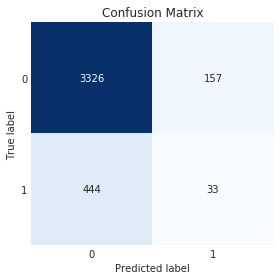

In [49]:
title = 'Confusion Matrix'
labels =list(np.unique(y))
cm = confusion_matrix(y_test, y_pred,labels=labels)
plt.figure(figsize = (4,4))
g = sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues",xticklabels=True,yticklabels=True)
g.set_yticklabels(labels, rotation =0)
g.set_xticklabels(labels, rotation =0)
plt.title(title)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

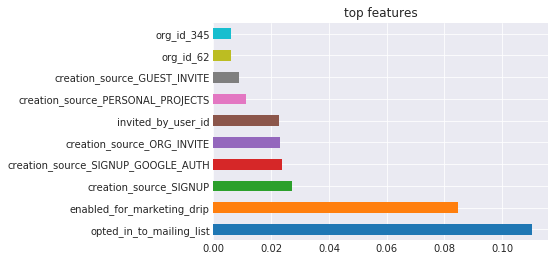

In [50]:
pd.Series(clf.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh') 
plt.title('top features')
plt.show()

In [51]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      0.95      0.92      3483
          1       0.17      0.07      0.10       477

avg / total       0.80      0.85      0.82      3960



## Results
Features that would result in future user adoption would be `org_id`, the organization the particular user they belong, when expanded, no particular organization id was usefull.

If user opted in to mailing list or enabled for marketing were a top feature.